# CRE/MF Mortgage Rate Model

# Setup

In [1]:
# Data libraries 
import pandas as pd
import missingno as msno

# ML libraries
import statistics
import random
import numpy as np
from numpy import argmax
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima.model import ARIMA
from arch.unitroot import PhillipsPerron
from arch.unitroot import ZivotAndrews
from arch.unitroot import DFGLS
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

### Load Data 

In [2]:
df = pd.read_csv("/Users/juanvalidmind/Dev/github/validmind/validmind-python/notebooks/datasets/lending_club_loan_rates.csv", sep='\t')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.set_index(pd.to_datetime(df['Date']))
df.drop(["Date"], axis=1, inplace=True)
df.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D,FEDFUNDS,diff1_loan_rate_A,diff1_loan_rate_B,diff1_loan_rate_C,diff1_loan_rate_D,diff1_FEDFUNDS,diff2_FEDFUNDS
Date,,,,,,,,,,,
2007-08-01,7.766667,9.497692,10.947500,12.267000,5.02,0.060000,0.134359,0.207500,-0.467444,-0.24,-0.25
2007-09-01,7.841429,9.276667,10.829167,12.436667,4.94,0.074762,-0.221026,-0.118333,0.169667,-0.08,0.16
2007-10-01,7.830000,9.433333,10.825926,12.737368,4.76,-0.011429,0.156667,-0.003241,0.300702,-0.18,-0.10
2007-11-01,7.779091,9.467778,10.967037,12.609444,4.49,-0.050909,0.034444,0.141111,-0.127924,-0.27,-0.09
2007-12-01,7.695833,9.387500,10.805000,12.478889,4.24,-0.083258,-0.080278,-0.162037,-0.130556,-0.25,0.02


### Visual Inspection

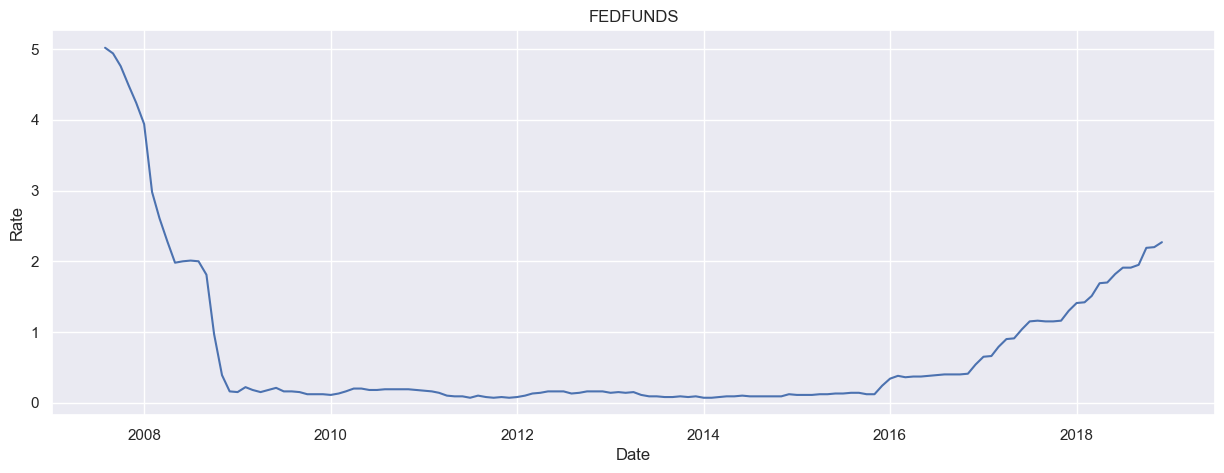

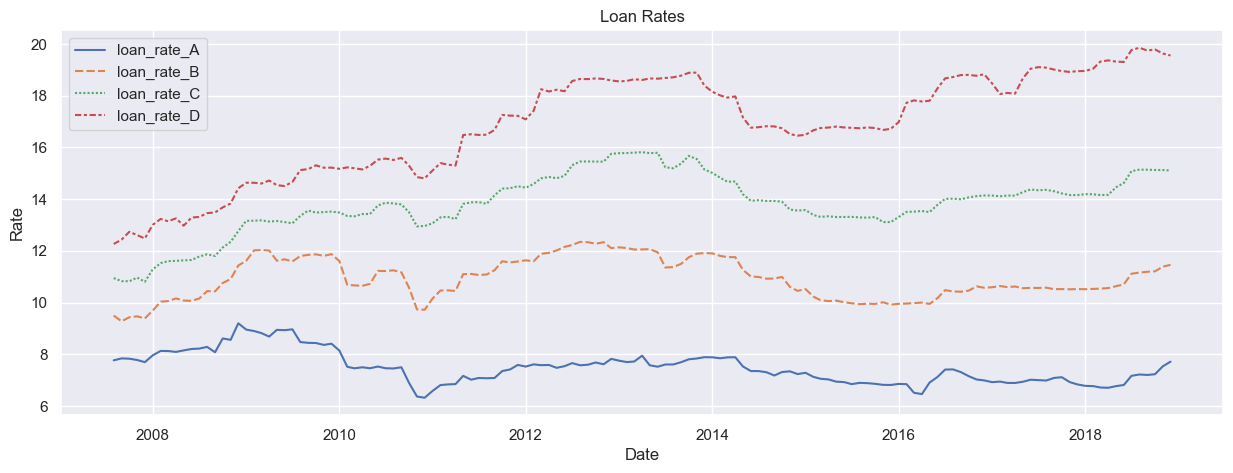

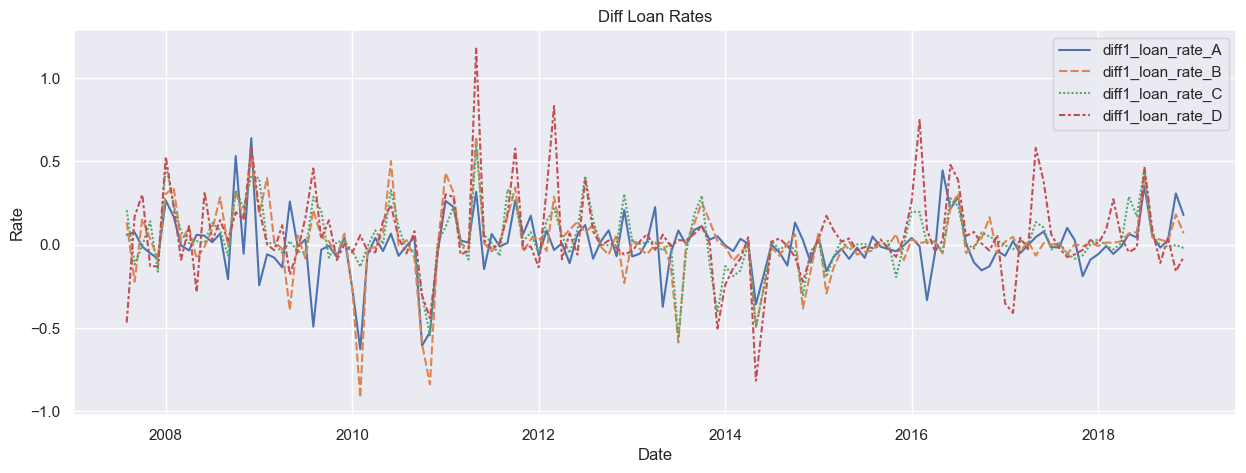

In [3]:
# FEDFUNDS plot
sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(data=df["FEDFUNDS"])
plt.title("FEDFUNDS")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

# Loan rates plot
loan_rates = df[["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]]
sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(data=loan_rates)
plt.title("Loan Rates")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

# Diff loan rates plot
diff_loan_rates = df[["diff1_loan_rate_A", "diff1_loan_rate_B", "diff1_loan_rate_C", "diff1_loan_rate_D"]]
sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(data=diff_loan_rates)
plt.title("Diff Loan Rates")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

# 4. Model Development

# 4.1. Development Data and Platform

## 4.1.2. Data Quality and Relevance

## 4.1.3. Data Process, Adjustments and Treatment

 ## A. Missing Values Analysis

**Step 1: Calculate the percentage of missing values in each column**

In [4]:
missing_values = df.isnull().sum() / len(df) * 100
missing_values_df = pd.DataFrame({"column_name": missing_values.index, "missing_percentage": missing_values.values})
missing_values_df = missing_values_df.sort_values("missing_percentage", ascending=False)

**Step 2: Display the missing values percentage in a table format**

In [5]:
display(missing_values_df)

,column_name,missing_percentage
0,loan_rate_A,0.0
1,loan_rate_B,0.0
2,loan_rate_C,0.0
3,loan_rate_D,0.0
4,FEDFUNDS,0.0
5,diff1_loan_rate_A,0.0
6,diff1_loan_rate_B,0.0
7,diff1_loan_rate_C,0.0
8,diff1_loan_rate_D,0.0
9,diff1_FEDFUNDS,0.0


**Step 3: Visualize the missing values**

Create a bar plot to show the missing values percentage per column.

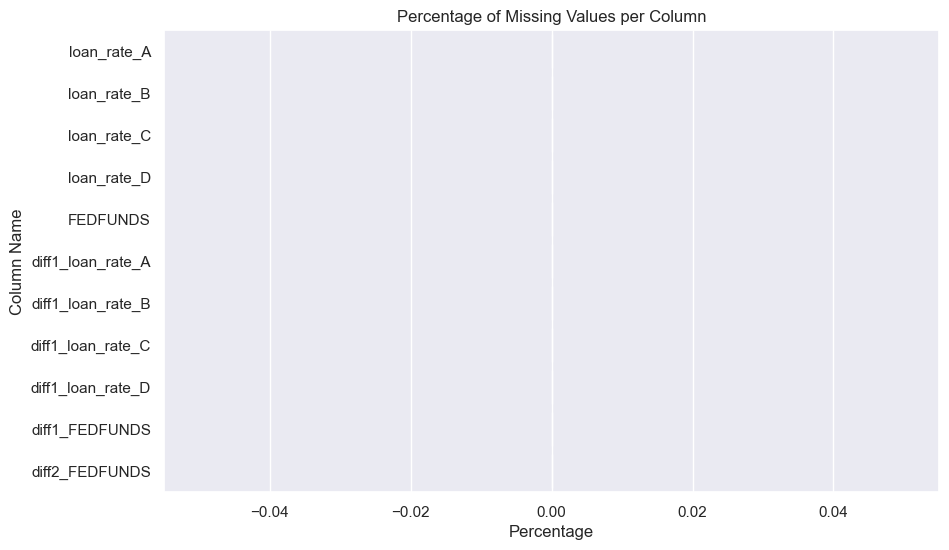

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(x="missing_percentage", y="column_name", data=missing_values_df, orient="h")
plt.title("Percentage of Missing Values per Column")
plt.xlabel("Percentage")
plt.ylabel("Column Name")
plt.show()

Create a matrix plot to show the pattern of missing values in the dataset.

<Figure size 1000x600 with 0 Axes>

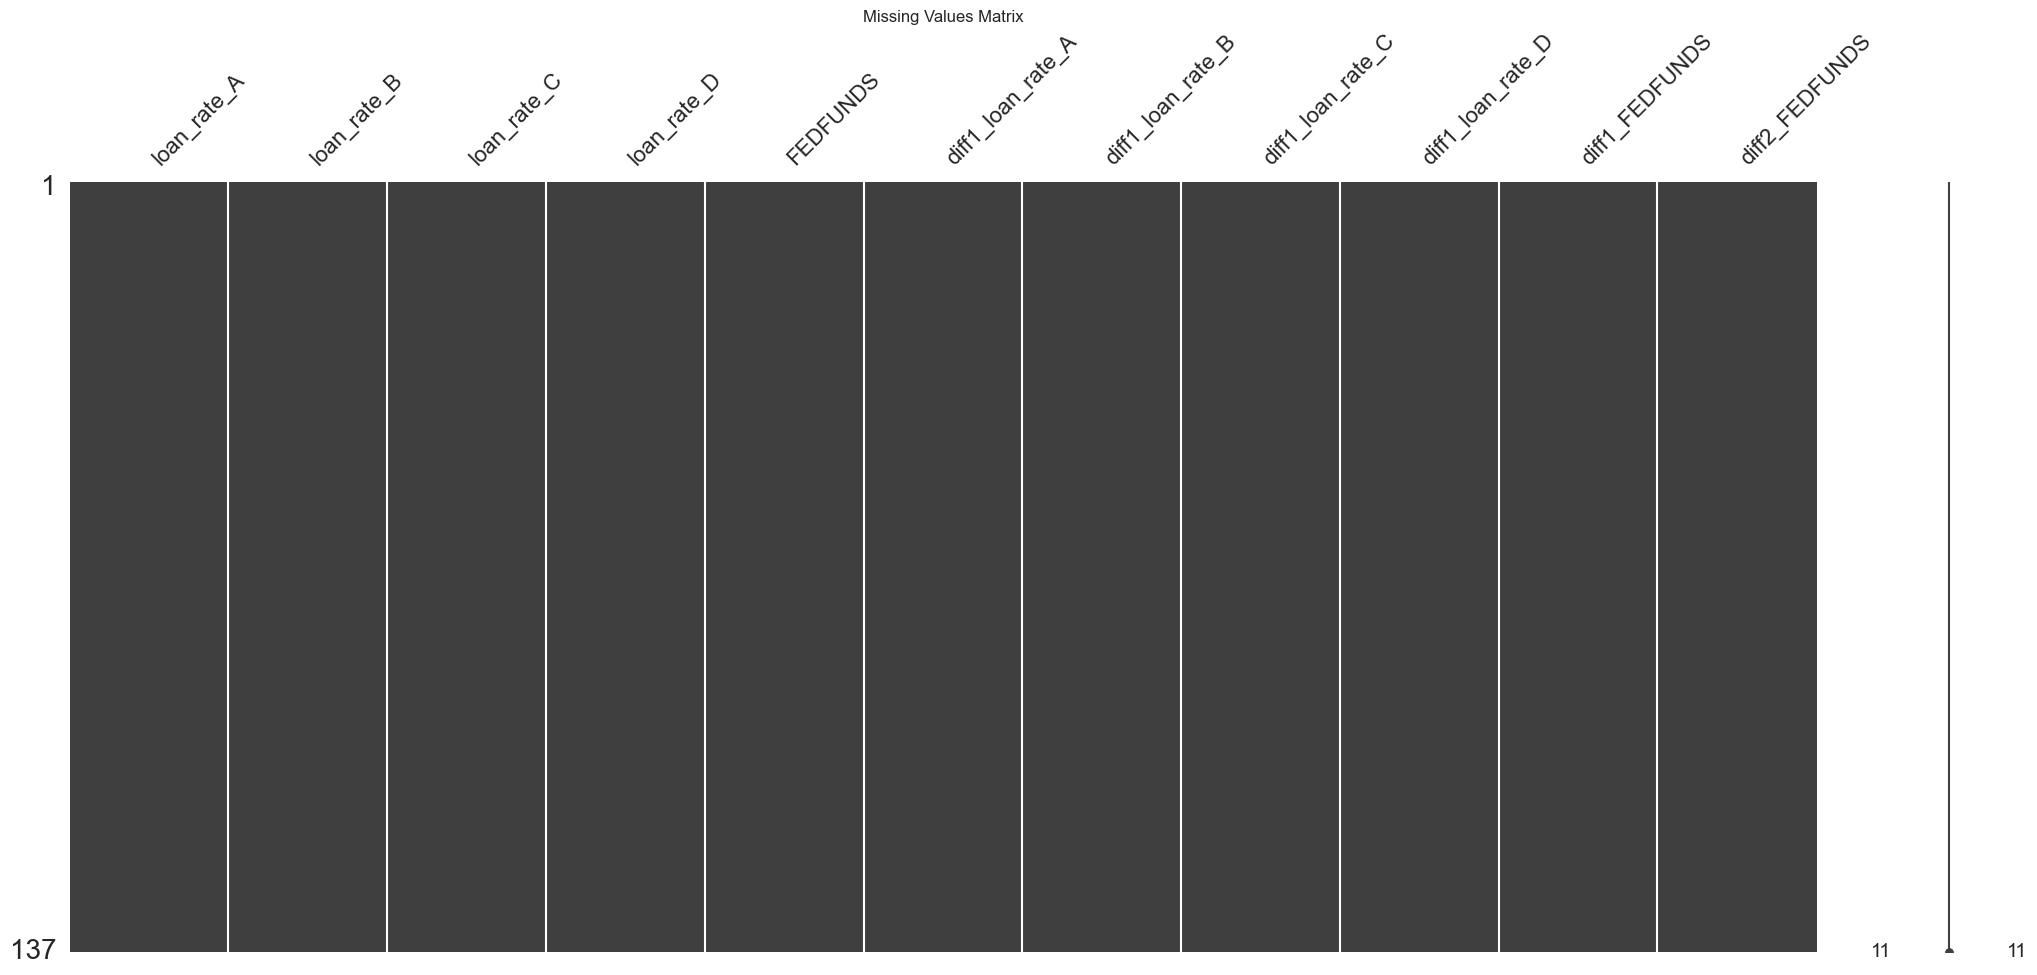

In [7]:
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title("Missing Values Matrix")
plt.show()

**Step 4: Analyze the patterns of missing values**

Based on the bar plot and matrix plot, analyze if the missing values are random or if there are specific patterns in the data.

**Step 5: Handle missing values**

Based on the analysis, decide how to handle the missing values. 

 ## B. Outliers Analysis

**Step 1: Visualize the dataset using box plots**

Visualize the data using box plots to get an initial sense of the presence of outliers.

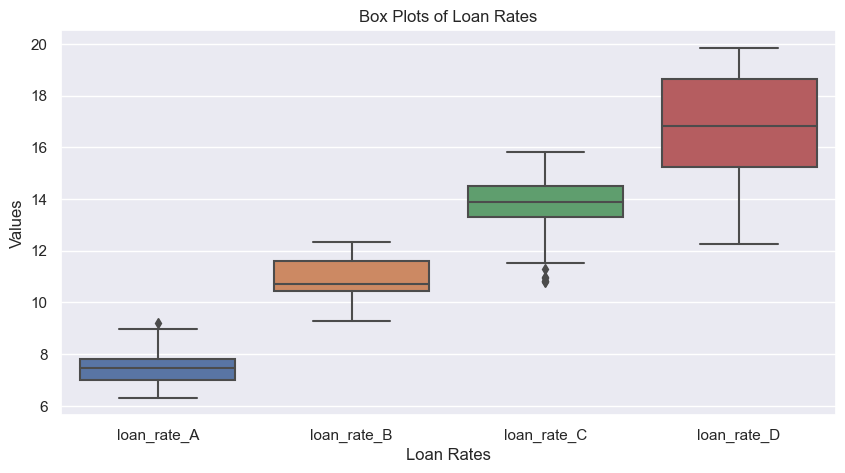

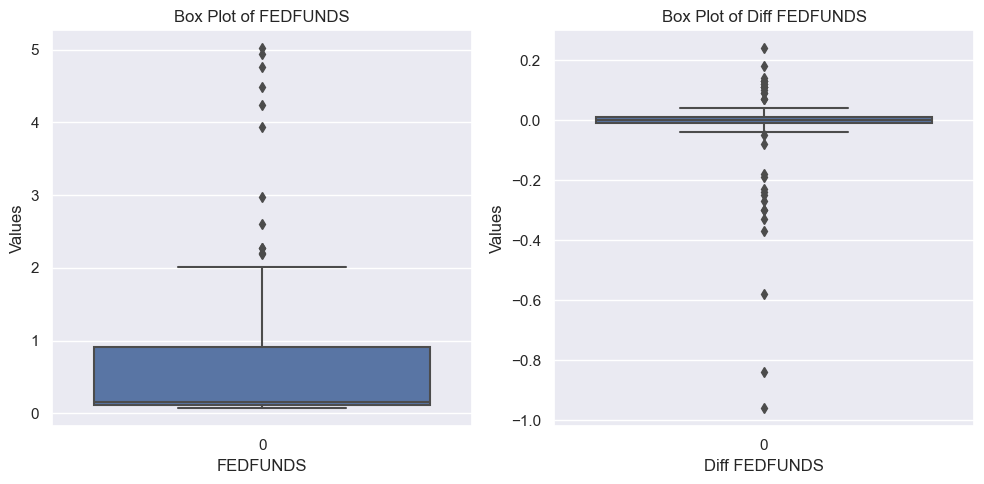

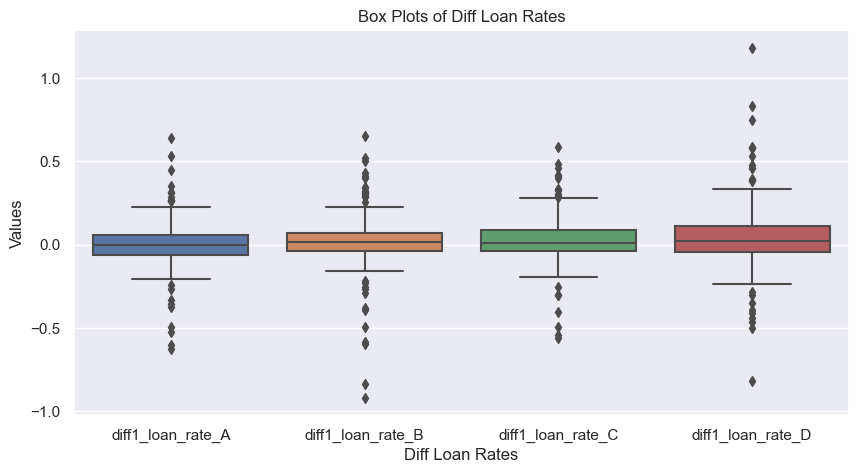

In [8]:
# Box plot for loan rates
loan_rates = df[["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]]
sns.set(rc={"figure.figsize": (10, 5)})
sns.boxplot(data=loan_rates)
plt.title("Box Plots of Loan Rates")
plt.xlabel("Loan Rates")
plt.ylabel("Values")
plt.show()

# Box plot for FEDFUNDS and diff FEDFUNDS
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=df["FEDFUNDS"], ax=axes[0])
axes[0].set_title("Box Plot of FEDFUNDS")
axes[0].set_xlabel("FEDFUNDS")
axes[0].set_ylabel("Values")

sns.boxplot(data=df["diff1_FEDFUNDS"], ax=axes[1])
axes[1].set_title("Box Plot of Diff FEDFUNDS")
axes[1].set_xlabel("Diff FEDFUNDS")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

# Box plot for diff loan rates
diff_loan_rates = df[["diff1_loan_rate_A", "diff1_loan_rate_B", "diff1_loan_rate_C", "diff1_loan_rate_D"]]
sns.set(rc={"figure.figsize": (10, 5)})
sns.boxplot(data=diff_loan_rates)
plt.title("Box Plots of Diff Loan Rates")
plt.xlabel("Diff Loan Rates")
plt.ylabel("Values")
plt.show()


**Step 2: Calculate Z-scores**

Calculate the Z-scores for each column in your dataset to identify data points that are far from the mean.

In [9]:
z_scores = np.abs(stats.zscore(df))

**Step 3: Set a threshold and identify outliers**

Set a threshold (e.g., 3) to identify data points with Z-scores higher than the threshold.

In [10]:
threshold = 3
outliers = np.where(z_scores > threshold)
outliers_df = pd.DataFrame({"row": outliers[0], "column": outliers[1]})

**Step 4: Analyze the outliers**

Analyze the outliers by looking at their frequency, index, and corresponding column.

In [11]:
outliers_count = outliers_df.groupby(["row", "column"]).size().reset_index(name="count")
outliers_info = outliers_count.merge(outliers_df, on=["row", "column"], how="left")

# Add the column names and dates to the outliers_info DataFrame
outliers_info["column_name"] = outliers_info["column"].apply(lambda x: df.columns[x])
outliers_info["date"] = outliers_info["row"].apply(lambda x: df.index[x])

# Reorder, sort by column_name, and display the DataFrame
outliers_info = outliers_info[["date", "column_name", "count"]].sort_values(by="column_name")
display(outliers_info)


,date,column_name,count
0,2007-08-01,FEDFUNDS,1
1,2007-09-01,FEDFUNDS,1
2,2007-10-01,FEDFUNDS,1
3,2007-11-01,FEDFUNDS,1
4,2007-12-01,FEDFUNDS,1
5,2008-01-01,FEDFUNDS,1
10,2008-10-01,diff1_FEDFUNDS,1
12,2008-11-01,diff1_FEDFUNDS,1
6,2008-02-01,diff1_FEDFUNDS,1
16,2010-10-01,diff1_loan_rate_A,1


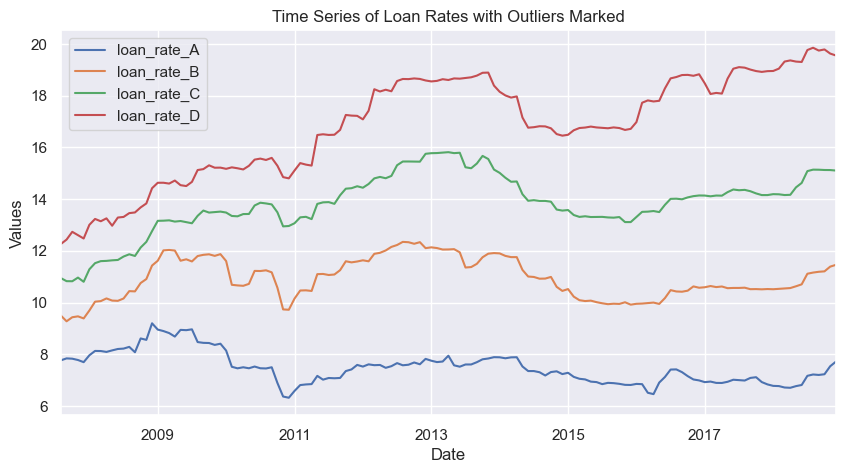

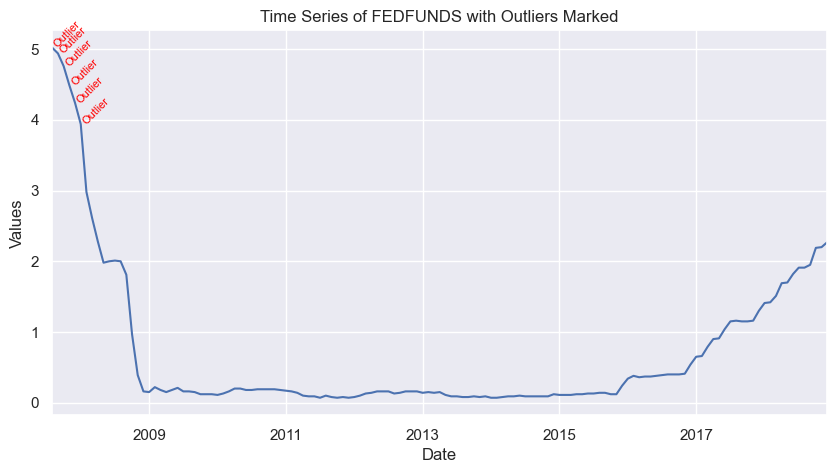

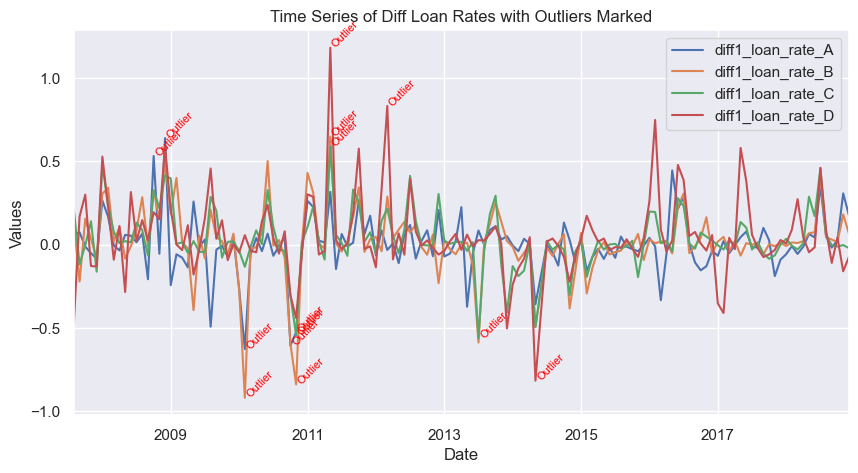

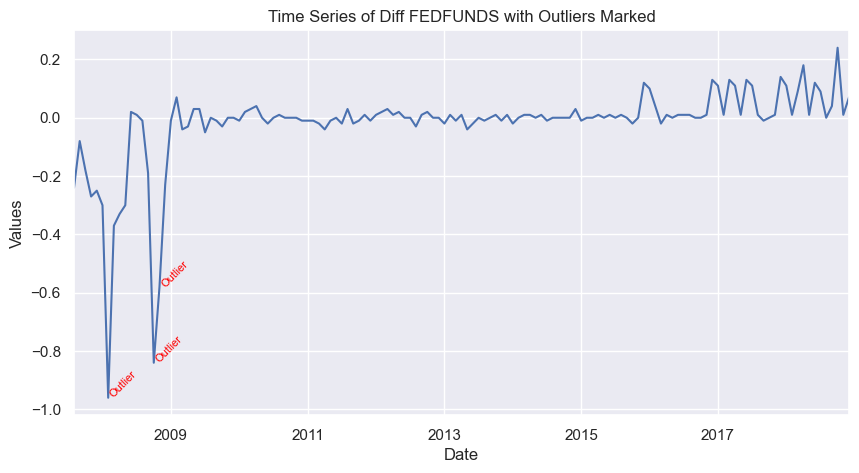

In [12]:
# Time series plot for loan rates with outliers marked
loan_rates = df[["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]]
loan_rates_outliers = outliers_info[outliers_info["column_name"].str.contains("loan_rate")]

fig, ax = plt.subplots(figsize=(10, 5))
loan_rates.plot(ax=ax)
loan_rates_outliers.apply(lambda x: ax.annotate('Outlier', xy=(x.date, df.loc[x.date][x.column_name]), 
                                                fontsize=8, color='red', rotation=45), axis=1)
plt.title("Time Series of Loan Rates with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

# Time series plot for FEDFUNDS with outliers marked
fed_funds_outliers = outliers_info[outliers_info["column_name"] == "FEDFUNDS"]

fig, ax = plt.subplots(figsize=(10, 5))
df["FEDFUNDS"].plot(ax=ax)
fed_funds_outliers.apply(lambda x: ax.annotate('Outlier', xy=(x.date, df.loc[x.date]["FEDFUNDS"]), 
                                               fontsize=8, color='red', rotation=45), axis=1)
plt.title("Time Series of FEDFUNDS with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

# Time series plot for diff loan rates with outliers marked
diff_loan_rates = df[["diff1_loan_rate_A", "diff1_loan_rate_B", "diff1_loan_rate_C", "diff1_loan_rate_D"]]
diff_loan_rates_outliers = outliers_info[outliers_info["column_name"].str.contains("diff1_loan_rate")]

fig, ax = plt.subplots(figsize=(10, 5))
diff_loan_rates.plot(ax=ax)
diff_loan_rates_outliers.apply(lambda x: ax.annotate('Outlier', xy=(x.date, df.loc[x.date][x.column_name]), 
                                                     fontsize=8, color='red', rotation=45), axis=1)
plt.title("Time Series of Diff Loan Rates with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

# Time series plot for diff FEDFUNDS with outliers marked
diff_fed_funds_outliers = outliers_info[outliers_info["column_name"] == "diff1_FEDFUNDS"]

fig, ax = plt.subplots(figsize=(10, 5))
df["diff1_FEDFUNDS"].plot(ax=ax)
diff_fed_funds_outliers.apply(lambda x: ax.annotate('Outlier', xy=(x.date, df.loc[x.date]["diff1_FEDFUNDS"]), 
                                                    fontsize=8, color='red', rotation=45), axis=1)
plt.title("Time Series of Diff FEDFUNDS with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()


## C. Seasonality Analysis

**Step 1: Seasonal decomposition**

Perform seasonal decomposition on each time series.

In [13]:
freq = 12  # Assuming monthly data, adjust the frequency accordingly

loan_rate_decompositions = {}
for col in loan_rates.columns:
    loan_rate_decompositions[col] = seasonal_decompose(df[col], model='additive', period=freq)

fed_funds_decomposition = seasonal_decompose(df["FEDFUNDS"], model='additive', period=freq)

diff_loan_rate_decompositions = {}
for col in diff_loan_rates.columns:
    diff_loan_rate_decompositions[col] = seasonal_decompose(df[col], model='additive', period=freq)


**Step 2: Visualize seasonal decomposition**

Create plots for seasonal components.

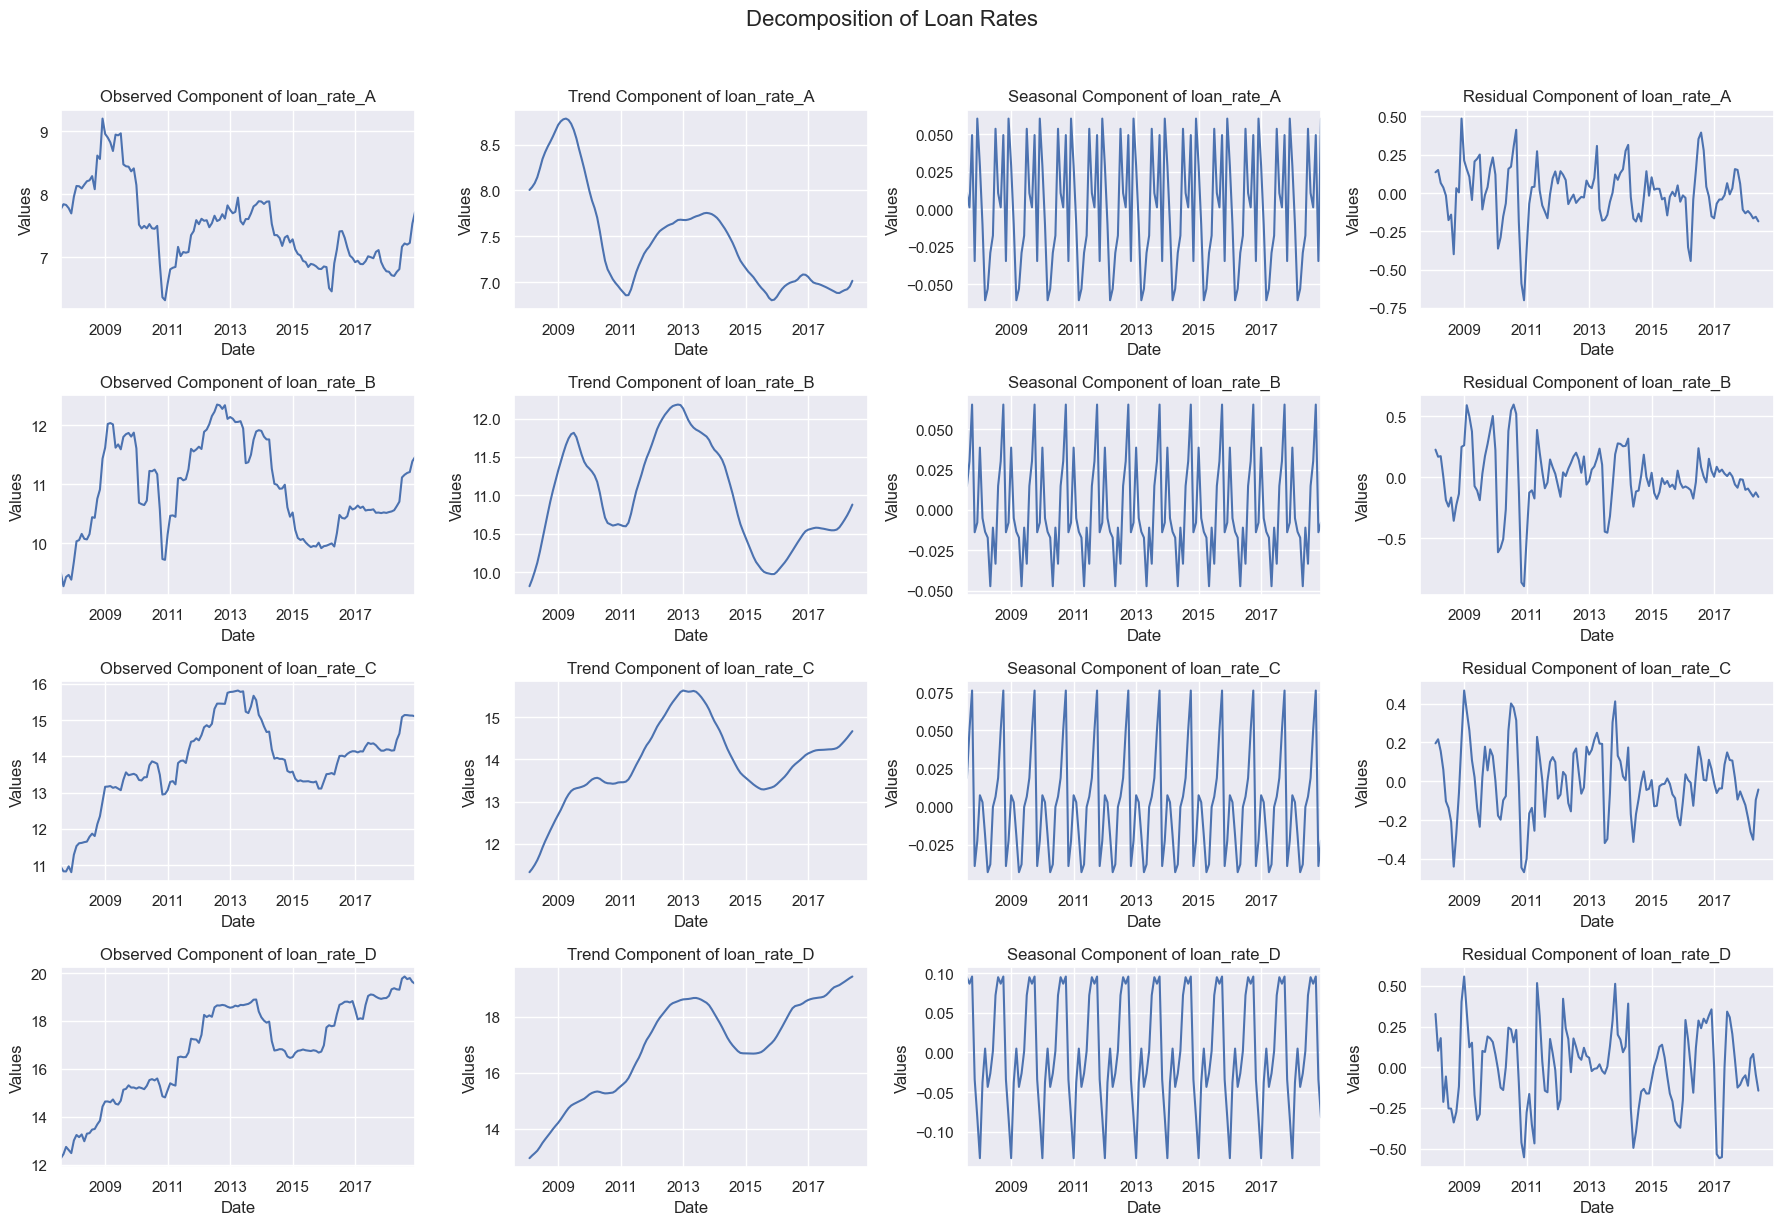

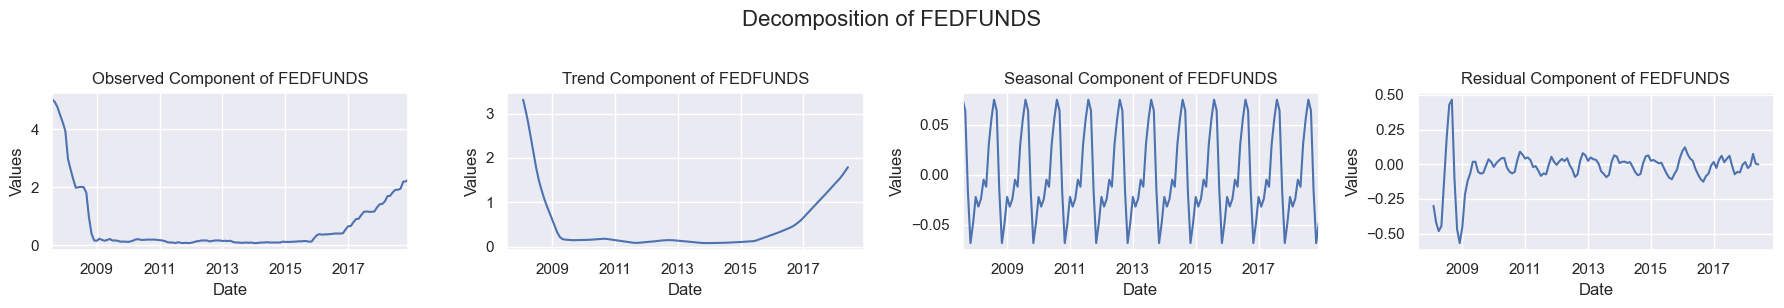

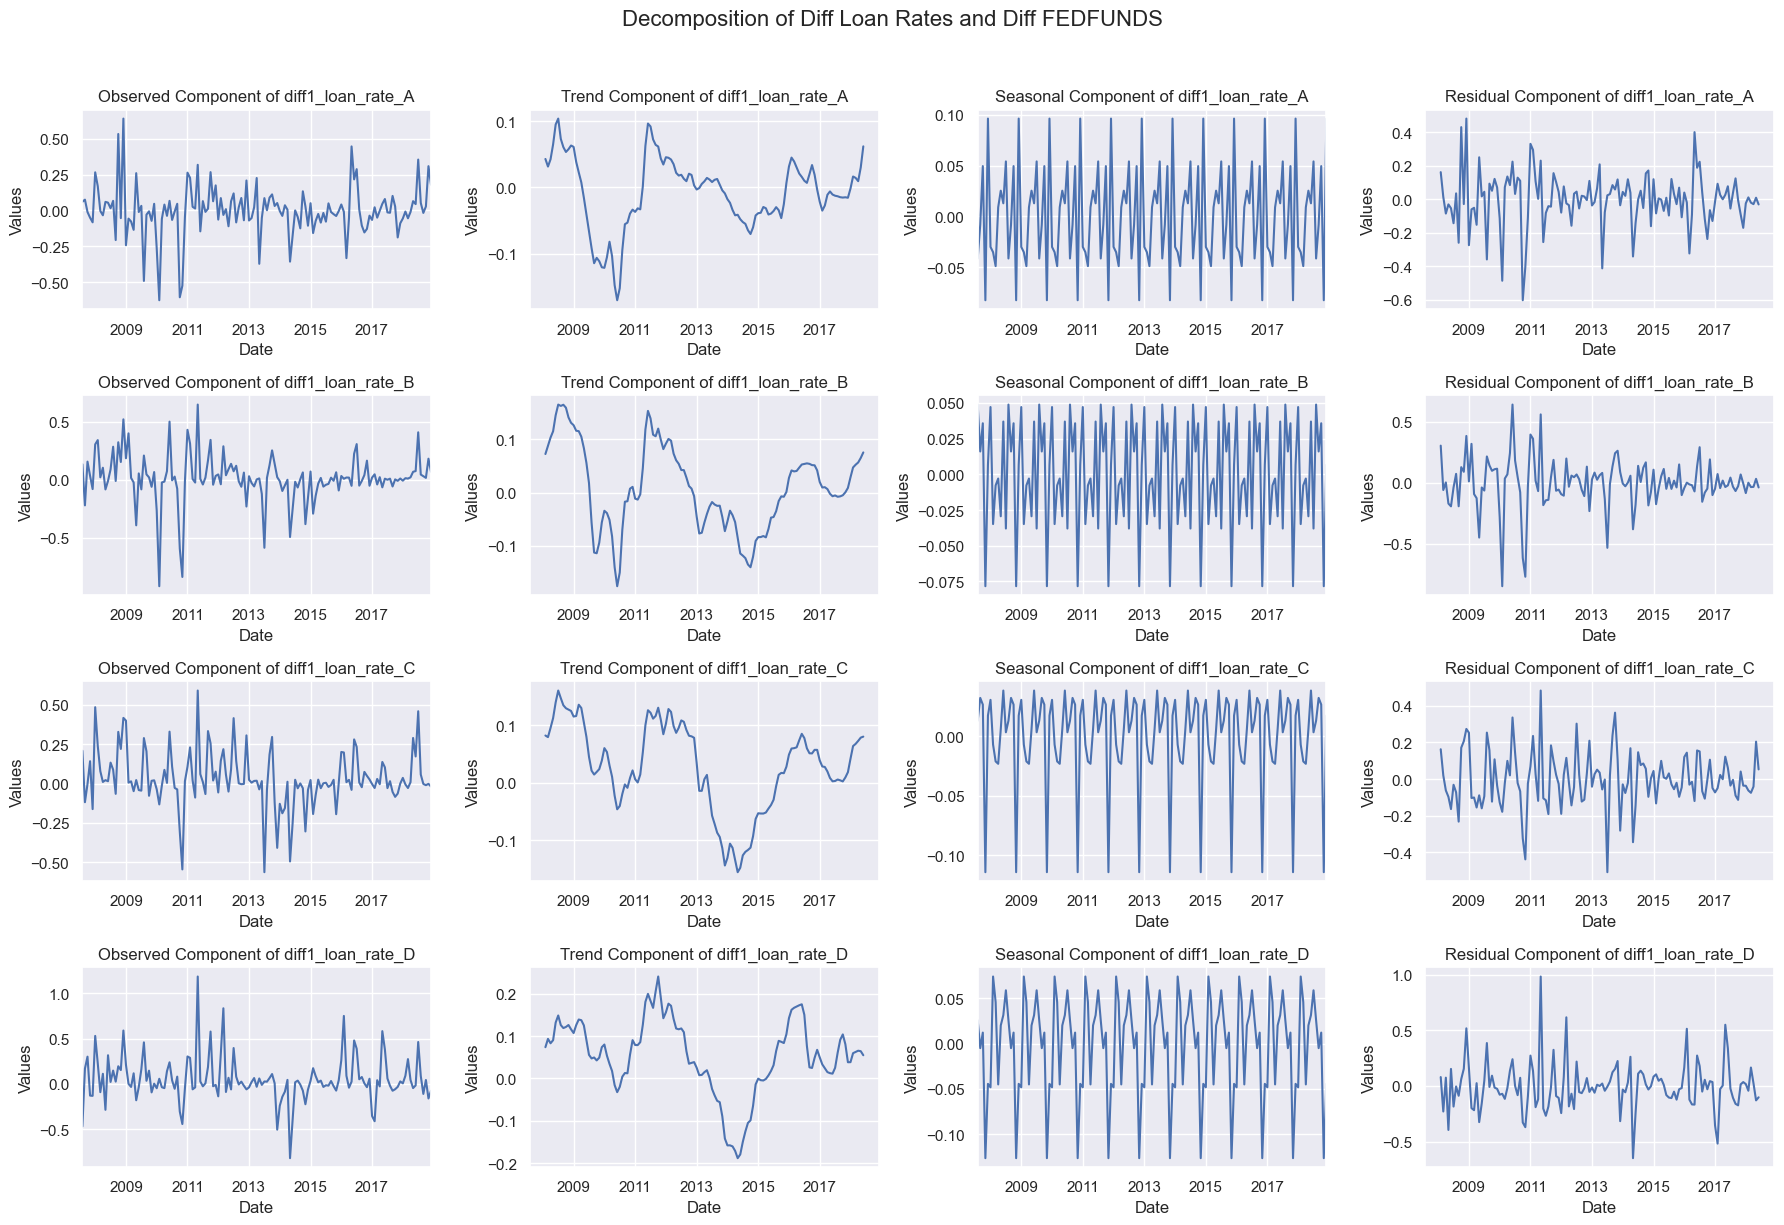

In [14]:
def plot_decomposition_components(series_decompositions, title):
    n = len(series_decompositions)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(18, 3 * n))
    
    if n == 1:
        axes = [axes]  # Make sure axes is a list even when there's only one subplot
    
    for row_axes, (col, decomposition) in zip(axes, series_decompositions.items()):
        for ax, component, comp_title in zip(row_axes, [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid],
                                            ["Observed", "Trend", "Seasonal", "Residual"]):
            component.plot(ax=ax)
            ax.set_title(f"{comp_title} Component of {col}")
            ax.set_ylabel("Values")
    
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_decomposition_components(loan_rate_decompositions, "Decomposition of Loan Rates")
plot_decomposition_components({"FEDFUNDS": fed_funds_decomposition}, "Decomposition of FEDFUNDS")
plot_decomposition_components(diff_loan_rate_decompositions, "Decomposition of Diff Loan Rates and Diff FEDFUNDS")

Create ACF plots.

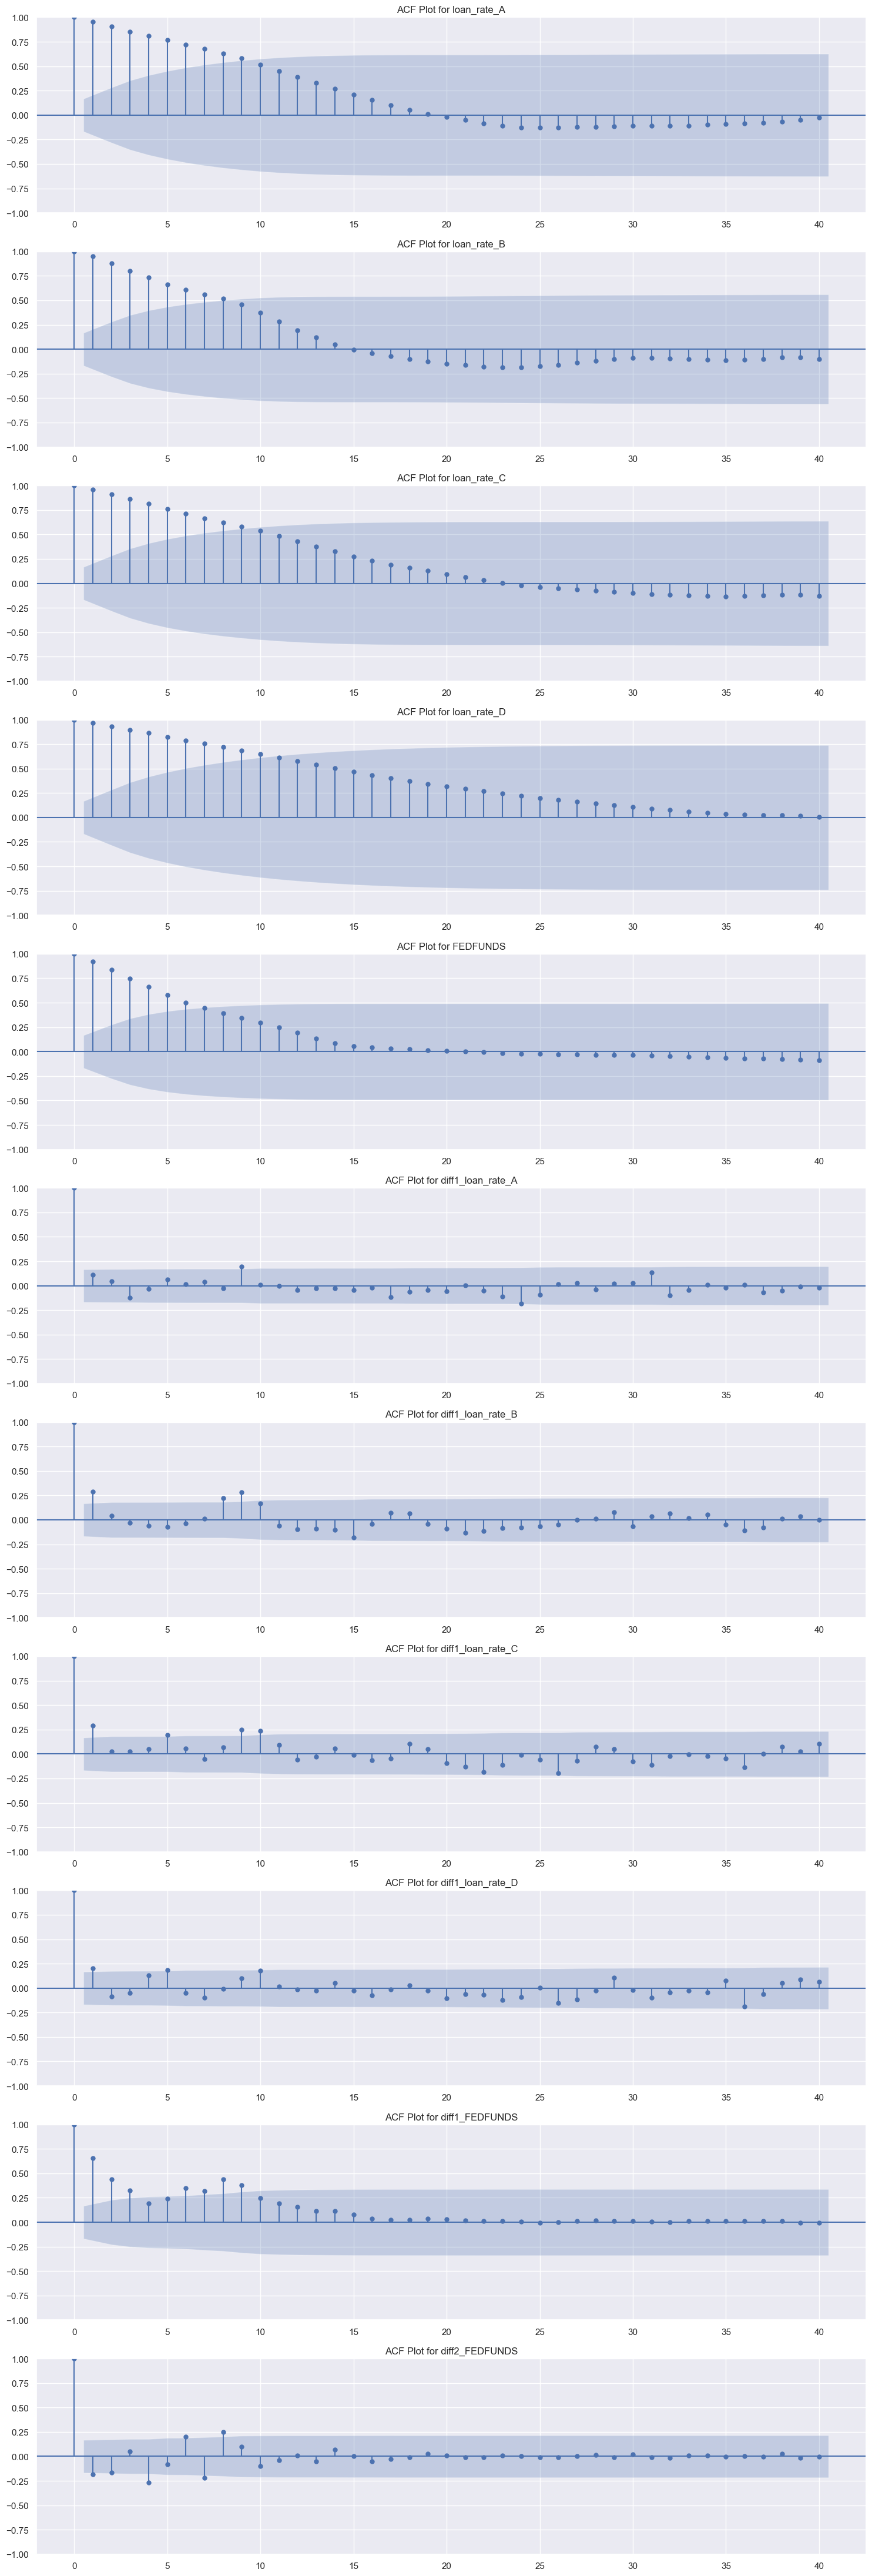

In [22]:

all_variables = [df['loan_rate_A'], df['loan_rate_B'], df['loan_rate_C'], df['loan_rate_D'], df['FEDFUNDS'], 
                 df['diff1_loan_rate_A'], df['diff1_loan_rate_B'], df['diff1_loan_rate_C'], df['diff1_loan_rate_D'], 
                 df['diff1_FEDFUNDS'], df['diff2_FEDFUNDS']]

# Create a figure with subplots
fig, ax = plt.subplots(11, 1, figsize=(15, 4*11))

# Plot ACF for each variable
for i, variable in enumerate(all_variables):
    plot_acf(variable, ax=ax[i], lags=40)
    ax[i].set_title("ACF Plot for {}".format(variable.name))

# Adjust the layout of the subplots
plt.tight_layout()


**Step 3: Residuals Analysis**

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


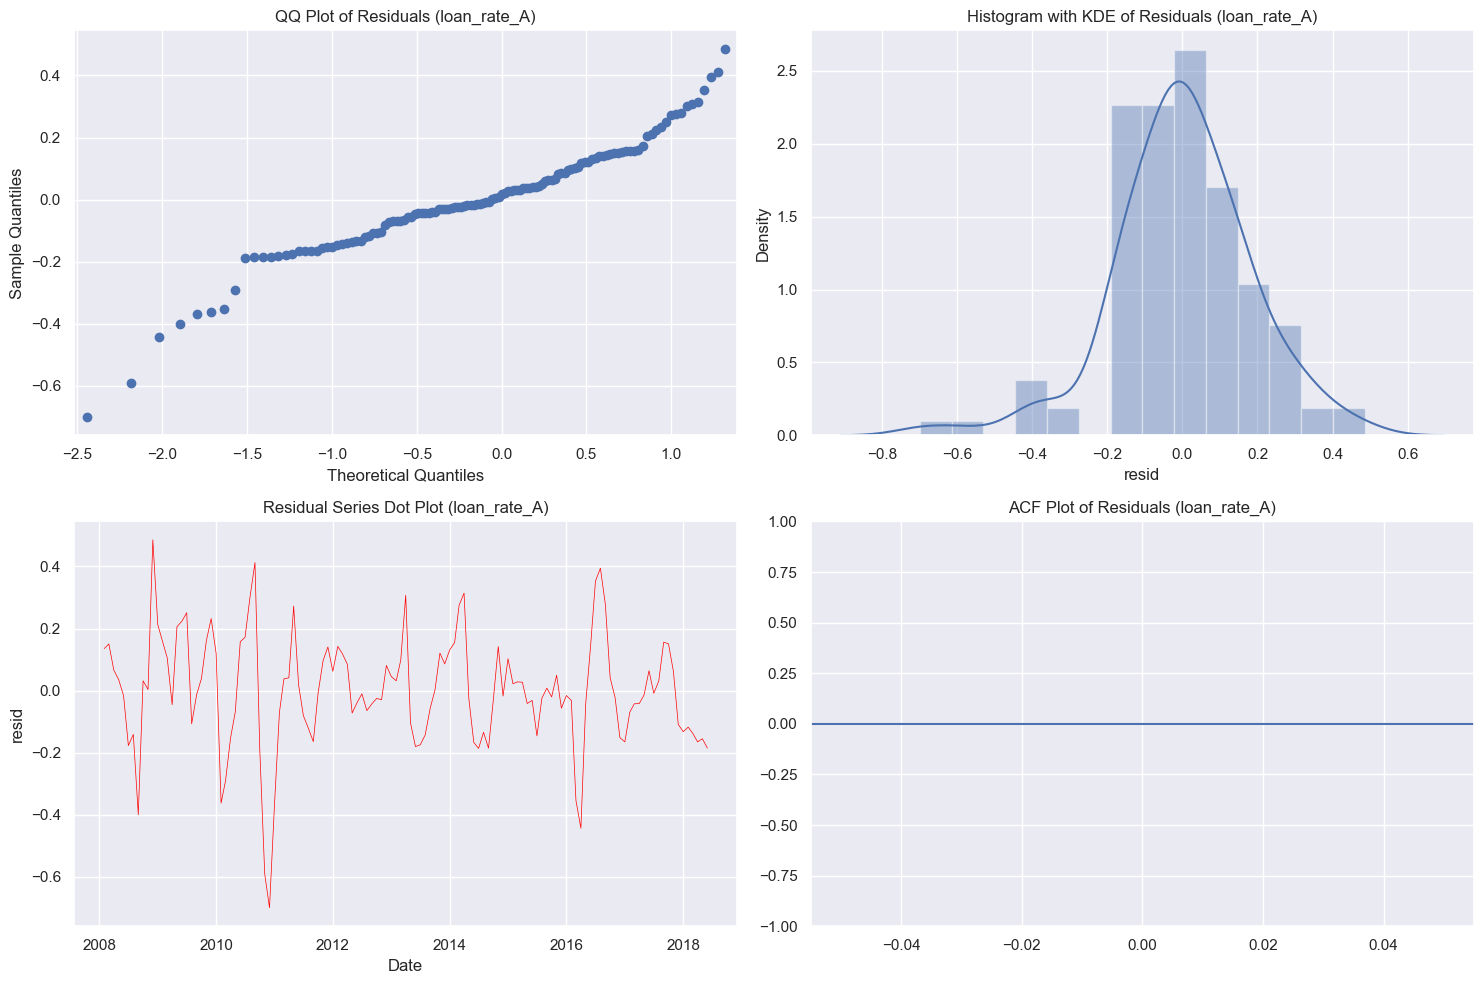

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


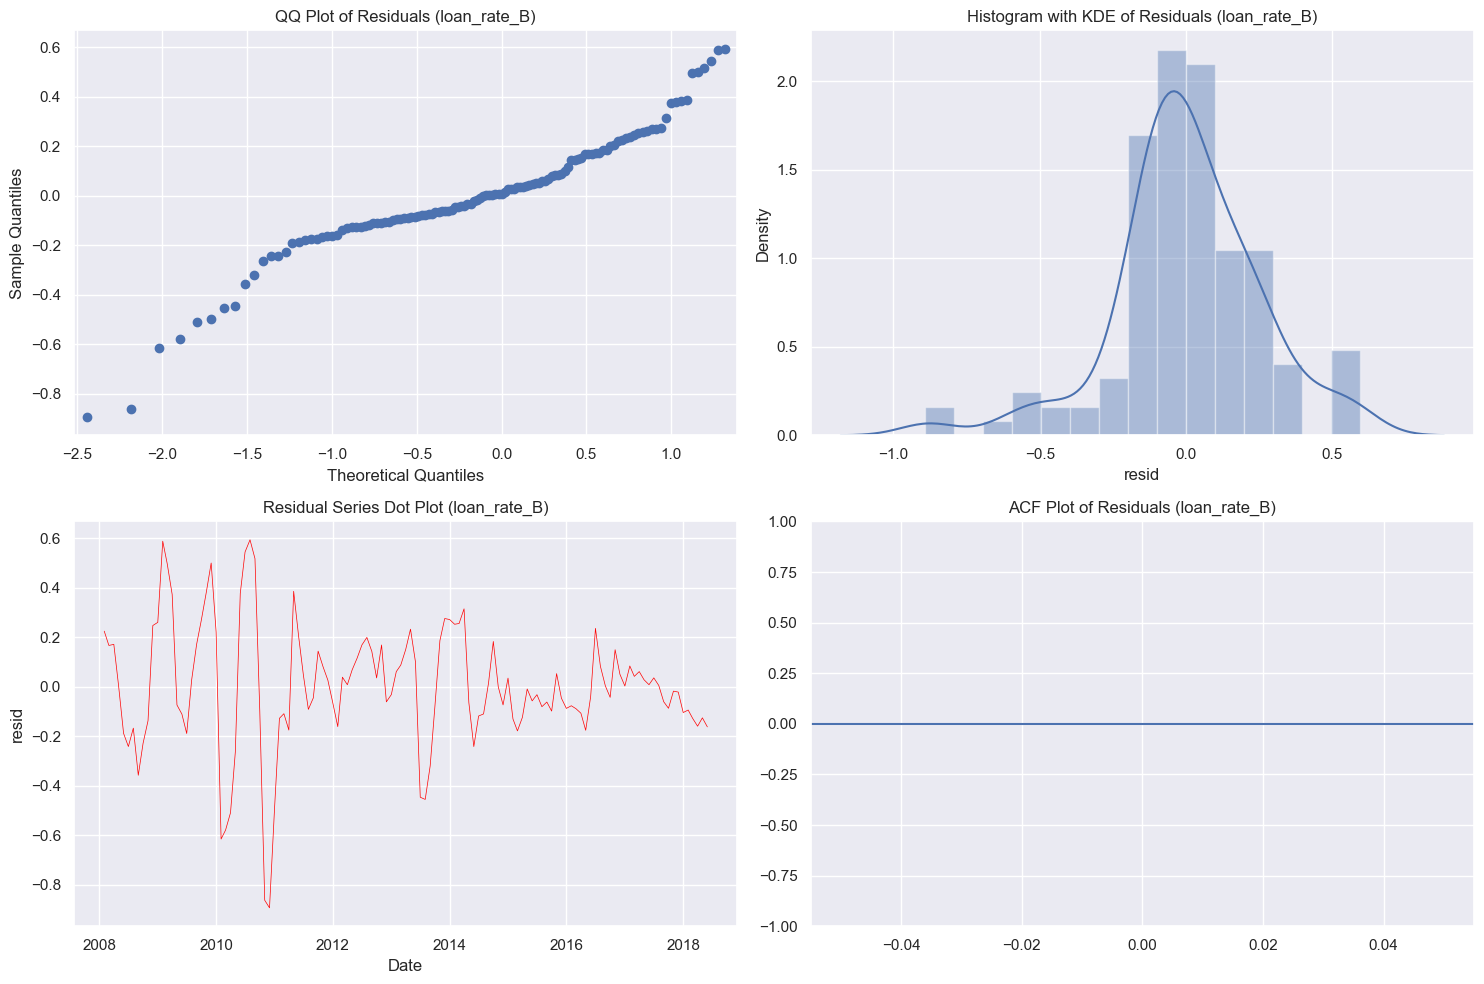

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


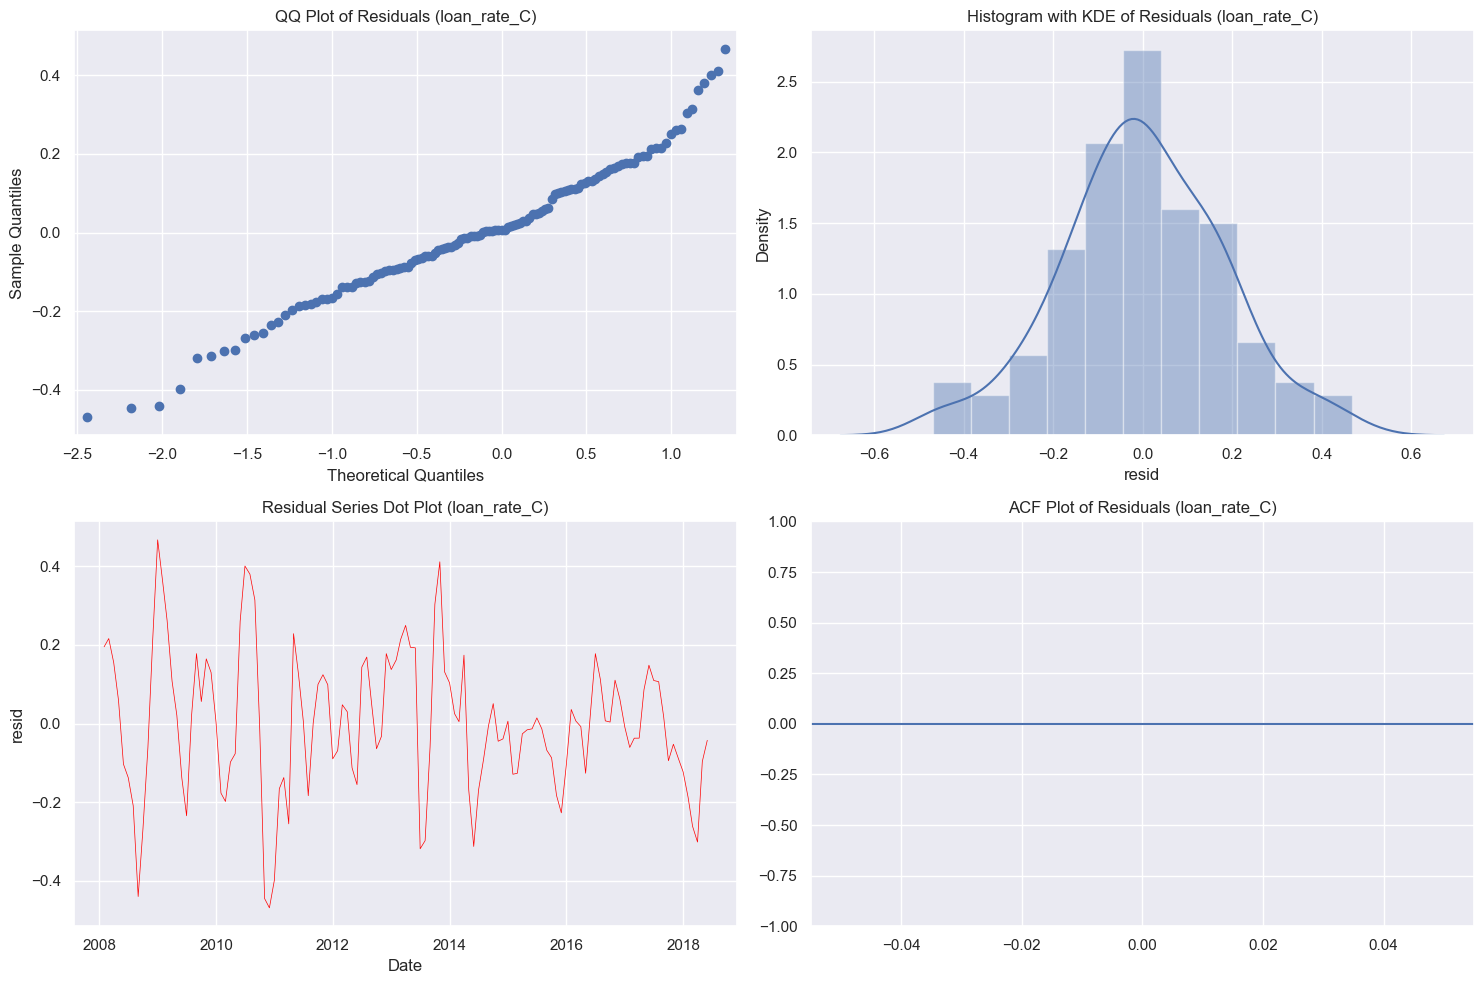

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


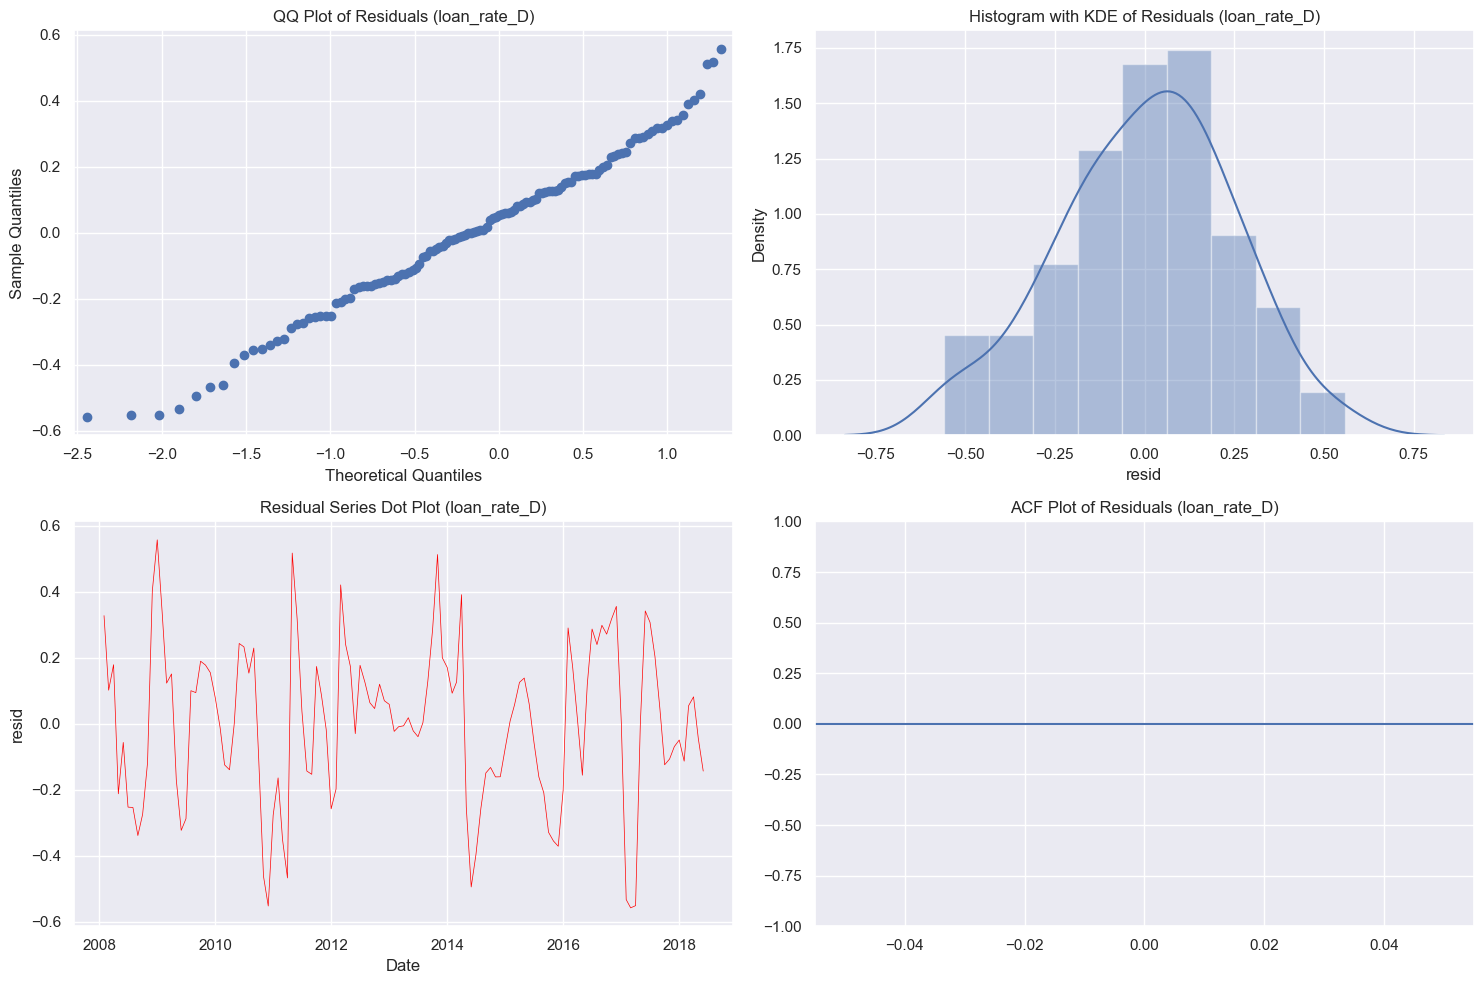

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


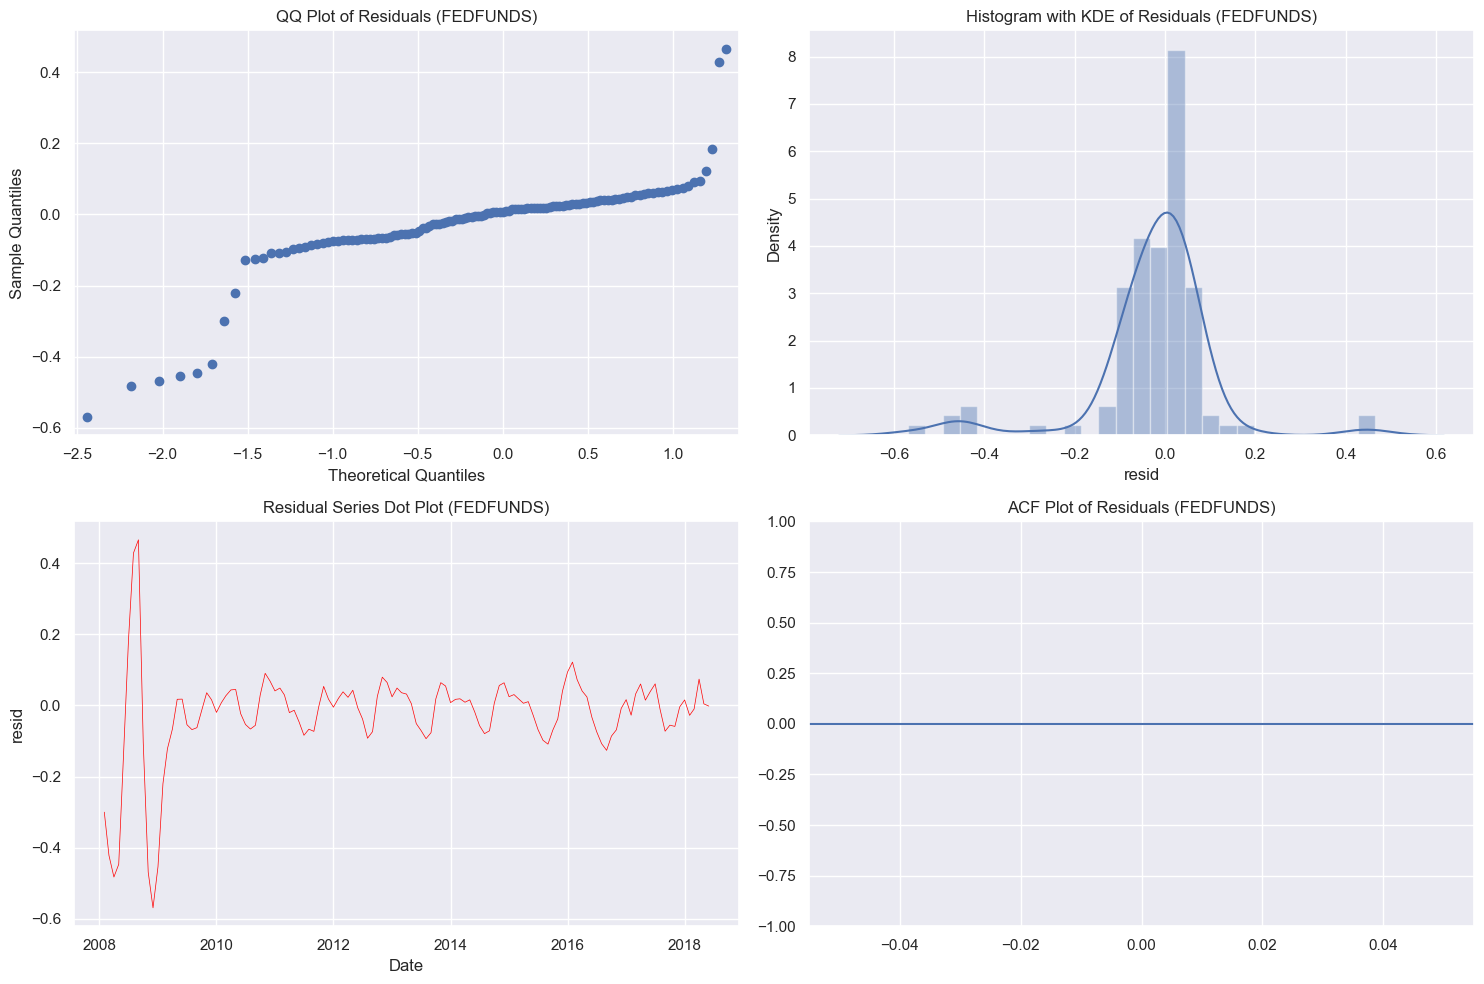

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


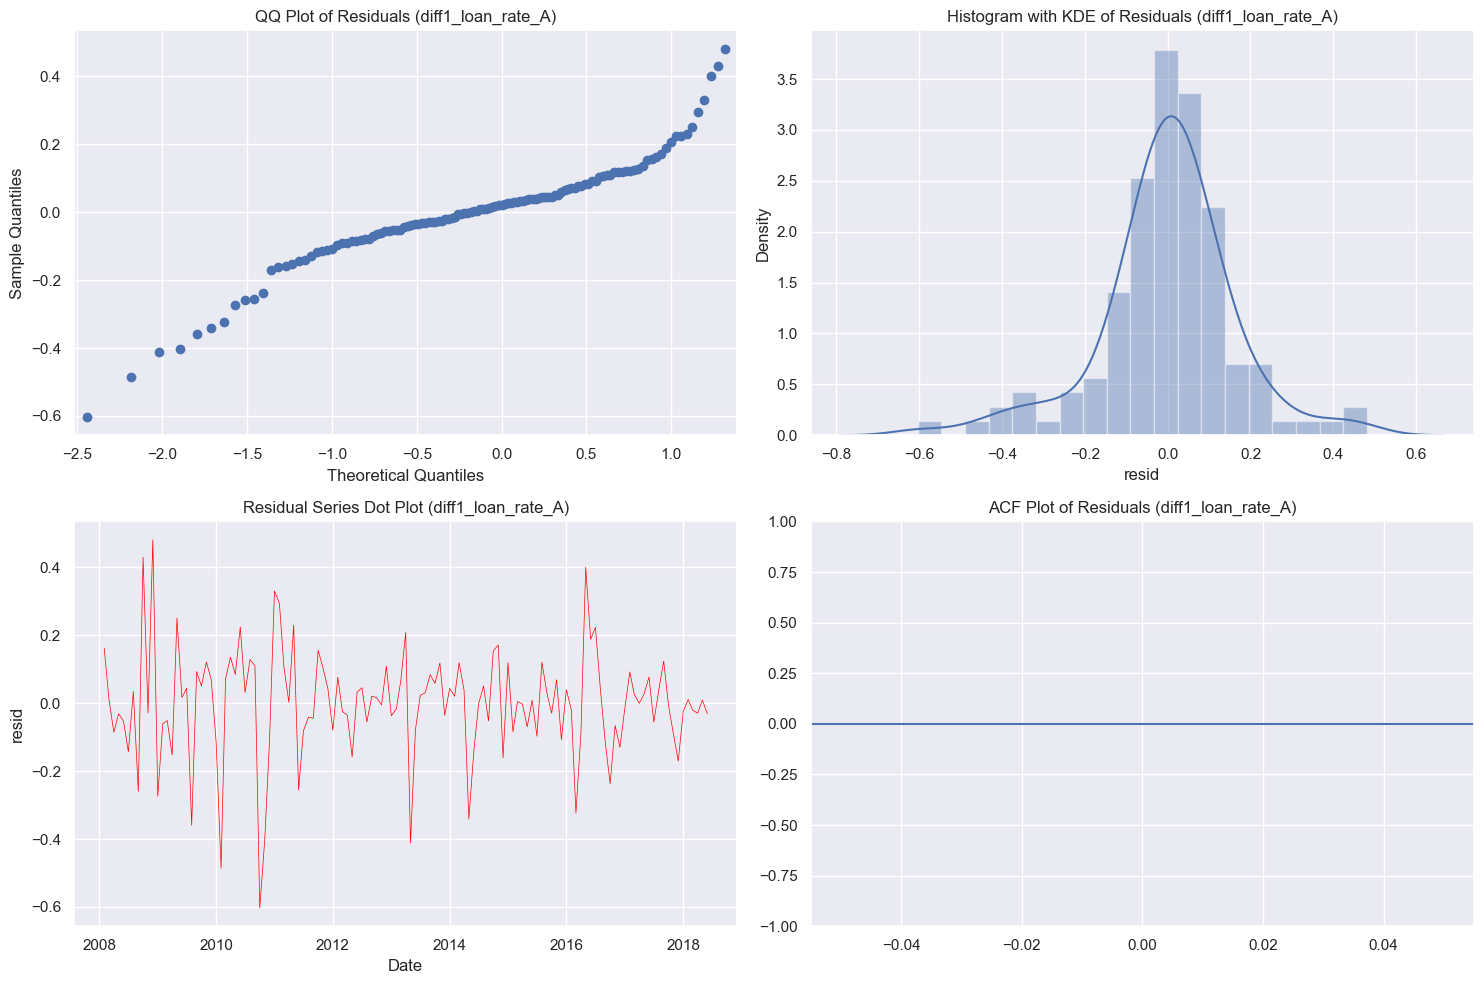

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


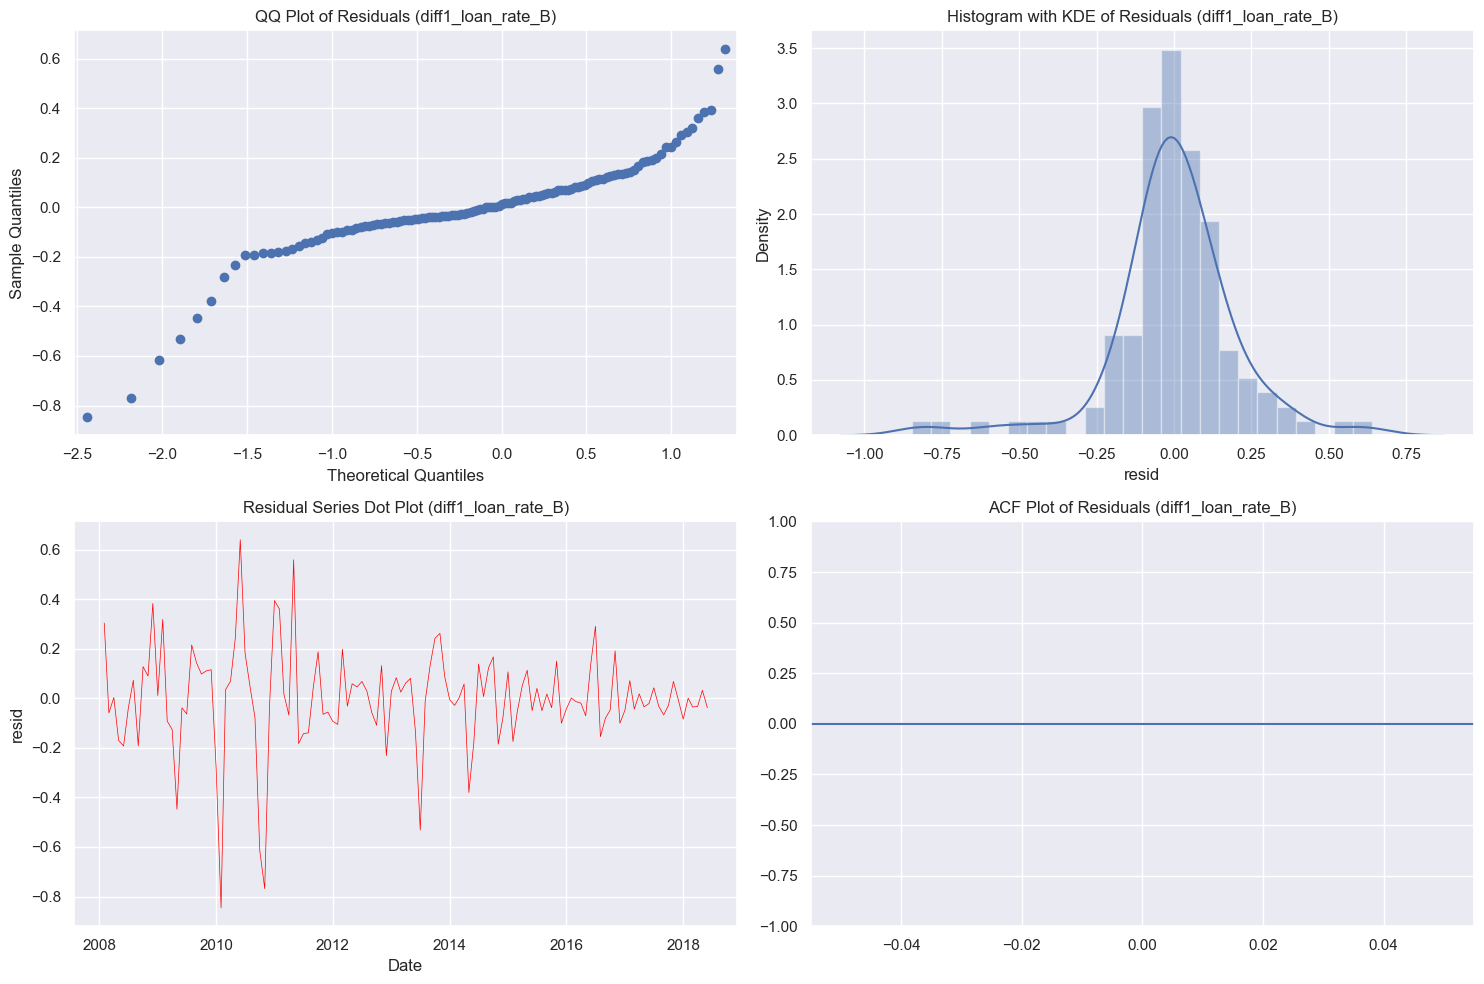

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


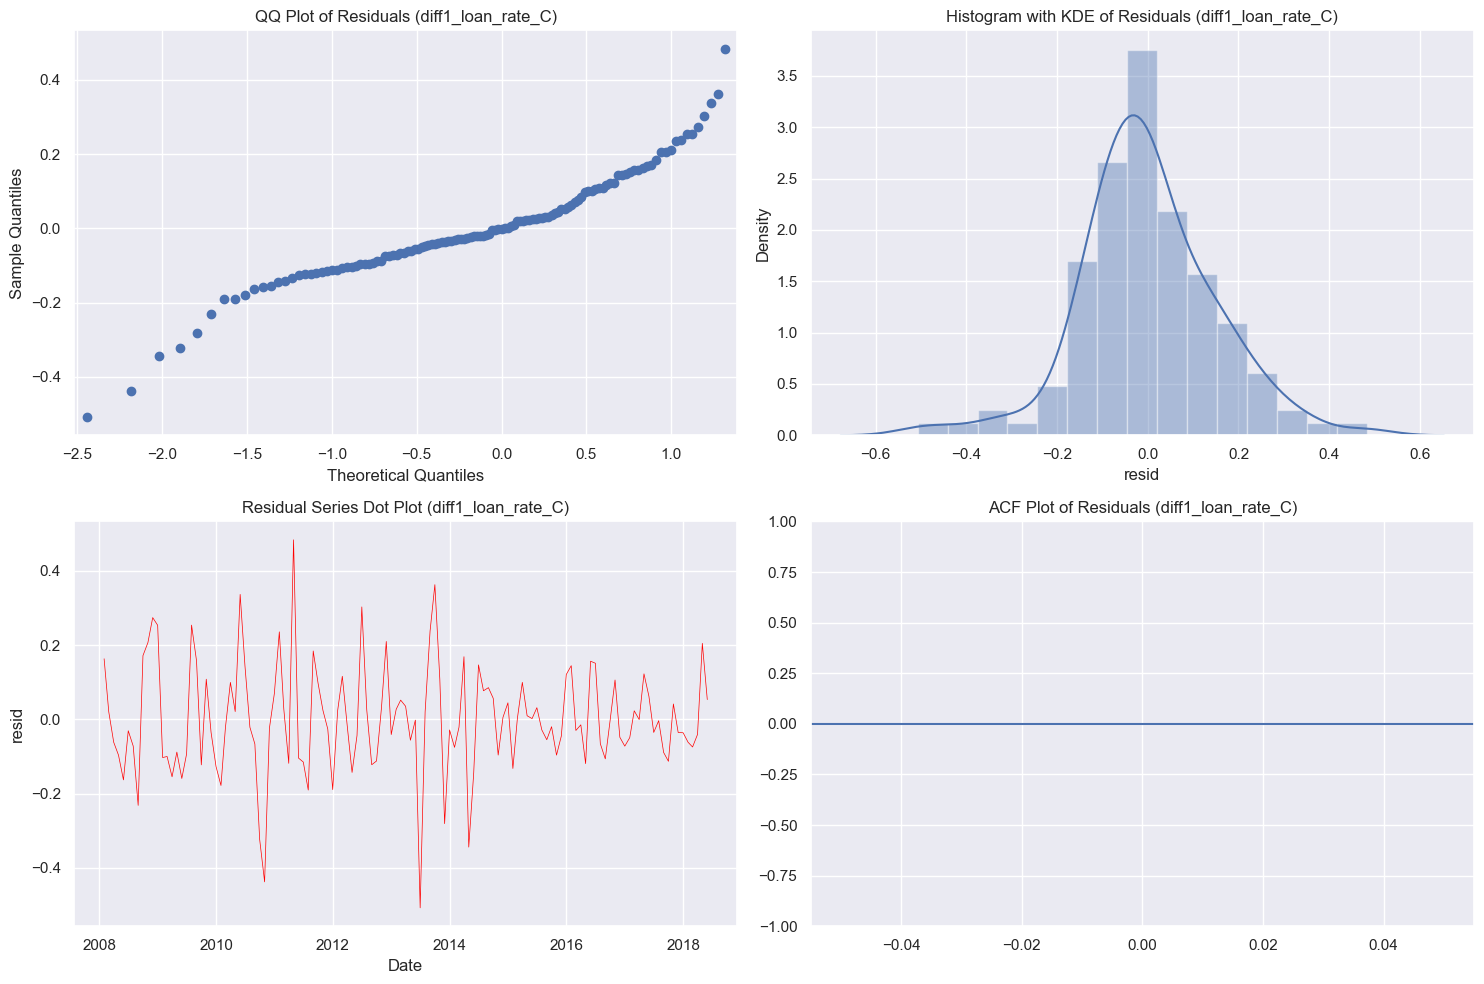

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


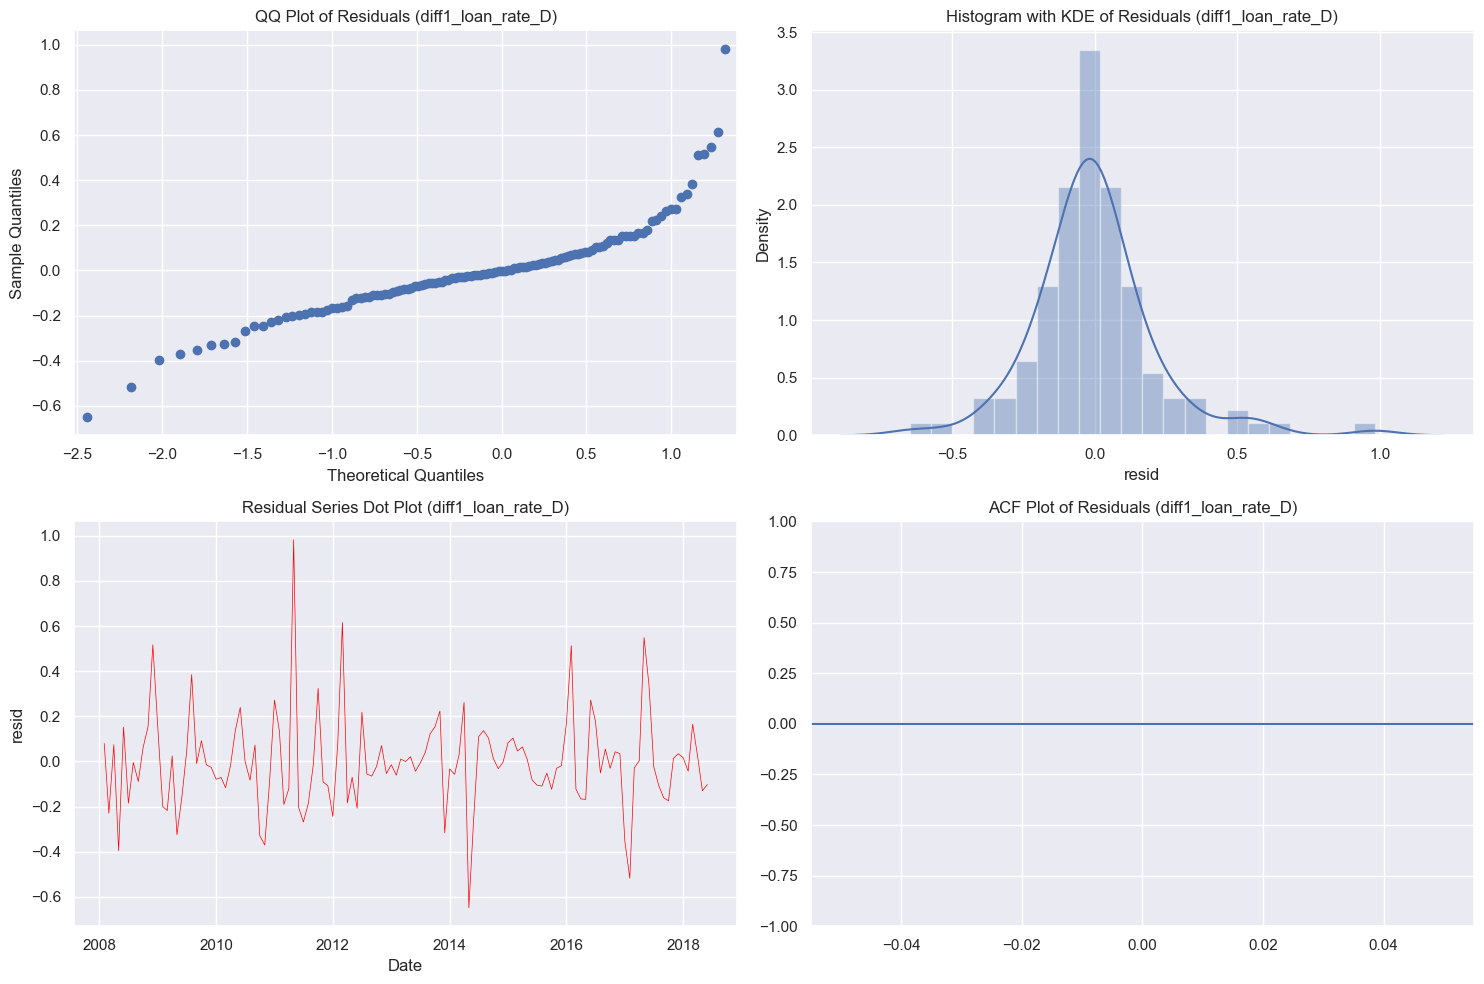

In [16]:
# Define a function to perform residual analysis
def residual_analysis(residuals, variable_name):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()
    
    # QQ plot
    qqplot(residuals, line='s', ax=ax[0])
    ax[0].set_title(f'QQ Plot of Residuals ({variable_name})')
    
    # Histogram with KDE
    sns.distplot(residuals, ax=ax[1])
    ax[1].set_title(f'Histogram with KDE of Residuals ({variable_name})')
    
    # Residual series dot plot
    sns.lineplot(data=residuals, linewidth=0.5, color='red', ax=ax[2])
    ax[2].set_title(f'Residual Series Dot Plot ({variable_name})')
    
    # ACF plot
    plot_acf(residuals, ax=ax[3], lags=100)
    ax[3].set_title(f'ACF Plot of Residuals ({variable_name})')
    
    plt.tight_layout()
    plt.show()

# Perform residual analysis for each variable
for variable_name in loan_rate_decompositions.keys():
    residual_analysis(loan_rate_decompositions[variable_name].resid, variable_name)

# Perform residual analysis for FEDFUNDS
residual_analysis(fed_funds_decomposition.resid, "FEDFUNDS")

# Perform residual analysis for each difference variable
for variable_name in diff_loan_rate_decompositions.keys():
    residual_analysis(diff_loan_rate_decompositions[variable_name].resid, variable_name)


**Step 3: Test for seasonality using the Augmented Dickey-Fuller (ADF) test**

In [38]:
def adf_test(series):
    result = adfuller(series)
    return {"ADF Statistic": result[0], "p-value": result[1]}

adf_results = []
for col in df.columns:
    if col != "Date":
        adf_result = adf_test(df[col])
        adf_results.append((col, adf_result["ADF Statistic"], adf_result["p-value"]))

adf_results_df = pd.DataFrame(adf_results, columns=["column_name", "ADF Statistic", "p-value"])


**Step 4: Analyze the seasonality test results**

In [39]:
display(adf_results_df)

,column_name,ADF Statistic,p-value
0,loan_rate_A,-1.917289,3.239719e-01
1,loan_rate_B,-3.159930,2.242441e-02
2,loan_rate_C,-2.530667,1.081899e-01
3,loan_rate_D,-1.617159,4.742193e-01
4,FEDFUNDS,-0.168543,9.421688e-01
5,diff1_loan_rate_A,-10.313828,3.134761e-18
6,diff1_loan_rate_B,-8.632056,5.720336e-14
7,diff1_loan_rate_C,-8.618071,6.211940e-14
8,diff1_loan_rate_D,-4.103447,9.558947e-04
9,diff1_FEDFUNDS,-3.632288,5.172913e-03


**Step 5: Interpret the results**

Based on the p-values from the ADF test, you can infer whether the time series are stationary or not. If the p-value is less than 0.05 (or your chosen significance level), you can reject the null hypothesis and conclude that the series is stationary. Otherwise, you fail to reject the null hypothesis and cannot conclude that the series is stationary.

**Step 6: Handle seasonality**

# 4.2. Methodology Selection and Development

## 4.2.4 Variable Analysis

  ## A. Feature Analysis

## A.1. Univariate Analysis

### **Visual Inspection**

## A.2 Multivariave Analysis

### **Visual Inspection**

## B. Variable Selection

## B.1 Selection Process

### **ARIMA Analysis**

**Step 1: Stationarity Analysis**

The first step in any time series analysis is to visualize the data and check for stationarity. Stationarity is important because most time series models, including ARIMA, assume that the underlying data is stationary.

Text(39.780328125, 0.5, 'ADF Statistic')

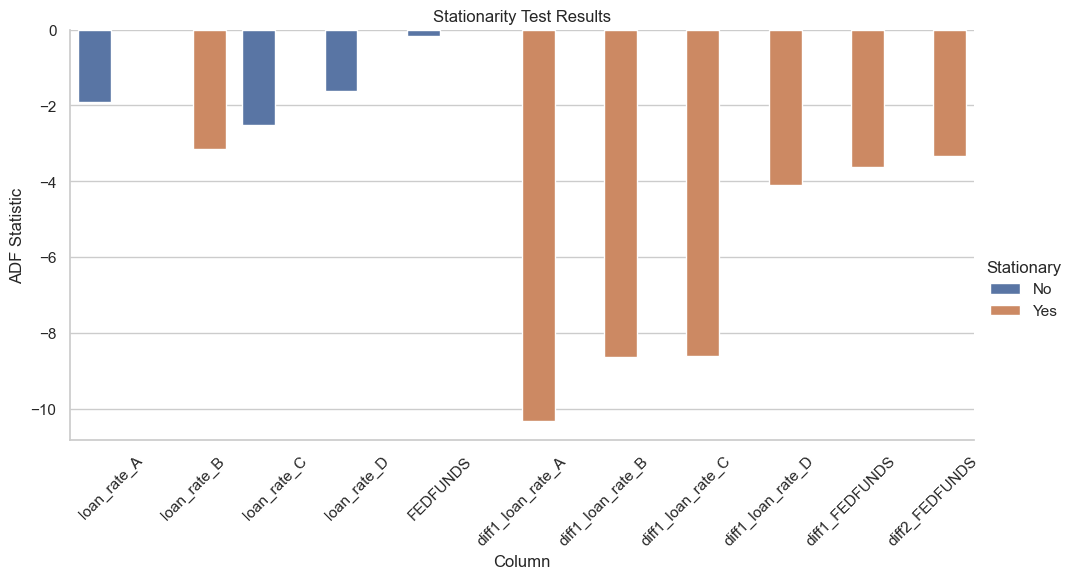

In [61]:
# Check stationarity for all columns
results = pd.DataFrame(columns=['Column', 'ADF Statistic', 'p-value', 'Stationary'])
for col in df.columns:
    # Perform ADF test
    result = adfuller(df[col])
    pval = result[1]
    stationary = 'Yes' if pval < 0.05 else 'No'
    results = results.append({'Column': col, 'ADF Statistic': result[0], 'p-value': pval, 'Stationary': stationary}, ignore_index=True)

# Display results in a table
sns.set(style='whitegrid')
table = sns.catplot(data=results, x='Column', y='ADF Statistic', hue='Stationary', kind='bar', height=5, aspect=2)
table.set_xticklabels(rotation=45)
table.ax.set_title('Stationarity Test Results')
table.ax.set_xlabel('Column')
table.ax.set_ylabel('ADF Statistic')




**Step 2: Identify the order of the AR model**

The order of the autoregressive (AR) model can be determined by looking at the partial autocorrelation function (PACF) plot. The PACF shows the correlation between a time series and its lagged values after accounting for the correlation at all shorter lags.

In [69]:
def find_ar_order(column, max_lag):
    pacf_values, pacf_confidence_intervals = pacf(column, nlags=max_lag, alpha=0.05, method="ywmle")
    
    for lag, pacf_value, ci in zip(range(len(pacf_values)), pacf_values, pacf_confidence_intervals):
        if pacf_value <= ci[1]:
            return lag - 1

    return None

max_lag = 10  # Maximum lag to consider
ar_orders = {}

for col in df.columns:
    ar_order = find_ar_order(df[col], max_lag)
    ar_orders[col] = ar_order

# Create a DataFrame from the ar_orders dictionary
ar_orders_df = pd.DataFrame.from_dict(ar_orders, orient='index', columns=['AR_order'])
ar_orders_df.reset_index(inplace=True)
ar_orders_df.columns = ['Column', 'AR_order']

# Display the DataFrame
display(ar_orders_df)


,Column,AR_order
0,loan_rate_A,-1
1,loan_rate_B,-1
2,loan_rate_C,-1
3,loan_rate_D,-1
4,FEDFUNDS,-1
5,diff1_loan_rate_A,-1
6,diff1_loan_rate_B,-1
7,diff1_loan_rate_C,-1
8,diff1_loan_rate_D,-1
9,diff1_FEDFUNDS,-1
